# Analysing battery electrodes

For this exemplary analysis, segmented data of a commercial NMC electrode from x-ray tomography [Usseglio-Viretta et. al. 2018](https://iopscience.iop.org/article/10.1149/2.0731814jes/pdf) is used which can be downloaded [here](https://www.nrel.gov/media/docs/libraries/tsdc/caebat/nmc-1-uncal-withcbd-w099-binarized.tif?sfvrsn=e7c3b3f0_1).

In [4]:
import numpy as np
import tifffile

In [9]:
path_to_tif = "../../nmc-1-cal-withcbd-w099-binarized.tif"
tif_file = tifffile.imread(path_to_tif)
structure = np.array(tif_file)
print("Stack shape:", structure.shape)

labels = {"pore":0, "NMC":1, "CBD":2}
boxsize = 100.7e-6 # physical domain in m
px = boxsize/structure.shape[0] # pixel resolution in m

Stack shape: (253, 253, 253)


## Microstructure metrics

As defined in the metrics module

In [ ]:
from taufactor import metrics

Start with volume fractions

In [14]:
volume_fractions = metrics.volume_fraction(structure , labels)
print(volume_fractions)

{'pore': 0.3589135706424713, 'NMC': 0.5010758638381958, 'CBD': 0.14001056551933289}


In [ ]:
surface_areas = metrics.specific_surface_area(structure, phases=labels)
print(surface_areas)

{'pore': 0.10478981247511081, 'NMC': 0.09562062418717428, 'CBD': 0.10431124835026596}


In [20]:
through_fraction = {}
for key, value in labels.items():
    through_fraction[key] = {}
    _, through_fraction[key]['x'] = metrics.extract_through_feature(structure, value, 'x', connectivity=None)
    # _, through_fraction[key]['y'] = metrics.extract_through_feature(structure, value, 'y', connectivity=None)
    # _, through_fraction[key]['z'] = metrics.extract_through_feature(structure, value, 'z', connectivity=None)

print( "With |  side  |  edge  | corner | connectivity")
for key, value in labels.items():
    print(f" x = | {through_fraction[key]['x'][0]:.4f} | {through_fraction[key]['x'][1]:.4f} | {through_fraction[key]['x'][2]:.4f} | % of {key} are connected")
    # print(f" y = | {through_fraction[key]['y'][0]:.4f} | {through_fraction[key]['y'][1]:.4f} | {through_fraction[key]['y'][2]:.4f} | % of {key} are connected")
    # print(f" z = | {through_fraction[key]['z'][0]:.4f} | {through_fraction[key]['z'][1]:.4f} | {through_fraction[key]['z'][2]:.4f} | % of {key} are connected")

With |  side  |  edge  | corner | connectivity
 x = | 0.9893 | 0.9976 | 0.9986 | % of pore are connected
 x = | 0.9981 | 0.9981 | 0.9985 | % of NMC are connected
 x = | 0.9815 | 0.9950 | 0.9969 | % of CBD are connected


## Tortuosity

In [21]:
import taufactor as tau

In [23]:
s = tau.Solver(structure == labels['pore'])
tau = s.solve()
print(tau)

converged to: [2.73451834] after: 700 iterations in: 10.4232s (0.0149 s/iter)
GPU-RAM currently allocated 593.82 MB (851.44 MB reserved)
GPU-RAM maximally allocated 723.61 MB (851.44 MB reserved)
[2.73451834]


Now lets try the multiphase solver. First we will set the diffusive voxels in the top half of the volume to have a phase 2 label.

[0 1 2]


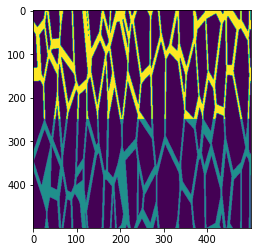

In [8]:
# solve in dim 1 cus it's faster and we are impatient
img2 = np.transpose(img, (1,0,2))
# Set some values to equal 2
img2[:250] *= 2
plt.imshow(img2[:,:,0])
print(np.unique(img2))

Now we solve using multiphase solver, with phase 0 non-conductive by default, phase 1 conductivity 1, phase 2 conductivity 5

In [9]:
mpsolver = taufactor.MultiPhaseSolver(img2, cond={1:1, 2:5})
mpsolver.solve()


converged to: 2.102311372756958                   after: 2500 iterations in: 107.192                    seconds at a rate of 0.0429 s/iter


tensor(2.1023)